# Introducción a la clasificación
Existen dos tipos de problemas de aprendizaje supervisado, los problemas de regresión, que consisten en generar un modelo que logre predecir valores en un rango continuo, y existen los problemas de clasificación, en donde las etiquetas son valores discretos el cual representan categorías. A continuación abordaremos los conceptos básicos de los problemas de clasificación en Machine Learning, utilizando la famosa base de datos MNIST

## Exploración de MNIST
MNIST es una base de datos compuesta por un set de 70.000 imágenes de caracteres escritos a mano, donde cada imagen tiene una etiqueta que corresponde al numero el cual está escrito en la imagen. Comenzaremos cargando los datos para explorar y conocer con lo que estamos trabajando.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

La variable `mnist` corresponde a un diccionario, las llaves más relevantes a considerar son `data` y `target` que corresponden a dos arrays con la matriz de características y las etiquetas respectivamente, la matriz está estructurada de tal forma que cada fila corresponde a una instancia de la base de datos, y cada columna es un atributo, veamos como es la estructura de la matriz y las etiquetas.

In [ ]:
X, y = mnist['data'], mnist['target']
print(f'Dimensiones Matriz atributos: {X.shape}')
print(f'Dimensiones Etiquetas: {y.shape}')

Dimensiones Matriz atributos: (70000, 784)
Dimensiones Etiquetas: (70000,)


Como podemos ver son 70.000 imagenes, con 784 atributos cada imagen y existe una etiqueta por cada entrada, cabe destacar que son 784 atributos porque cada imagen son **28x28 pixeles**, y cada atributo simplemente corresponde a la intensidad de cada pixel, cuyo valor es de **0 a 255**. Veamos a continuacion en pantalla una de las imagenes que componen esta base de datos.

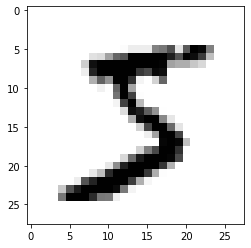

Dígito: 5


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

digit = X[0]
digit = digit.reshape(28, 28)

plt.imshow(digit, cmap="binary")
plt.show()
print(f'Dígito: {y[0]}')

Si observamos la etiqueta correspondiente al digito, podemos ver que corresponde al numero 5, tal cual como se puede observar en la imagen. El único problema, es que los dígitos en realidad son caracteres, asi que procederemos a convertirlos en formato numérico.

In [ ]:
import numpy as np
y = y.astype(np.uint8)

Antes de partir, procederemos a crear un subconjunto de testeo y de entrenamiento, la base de datos ya viene segmentada en dichos conjuntos, las primeras 60.000 imagenes corresponden al conjunto de entrenamiento y las últimas 10.000 al conjunto de testeo.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Clasificación Binaria

Comenzaremos nuestra aventura explorando el problema de clasificación binaria, es decir cuando la etiqueta puede ser sólamente dos valores posibles, no entraremos en profundizar el funcionamiento de algoritmos de clasificación, sino entenderemos el problema en general y entender cómo y cuando nuestro modelo funciona correctamente. Nuestro problema de clasificación binaria consistirá en predicir si un valor dado es el numero 5 o no, para esto crearemos una nueva lista de etiquetas, en donde cada valor puede ser verdadero o falso, en base a si el numero es 5 o no.

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5)

[ True False False ...  True False False]


Para abordar el problema utilizaremos un clasificador de *descenso del gradiente estocástico* y analizaremos su eficacia.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Medir el desempeño de un modelo de clasificación no es tan sencillo como es el caso de un modelo de regresión, para ilustrar lo anterior, crearemos un clasificador ineficiente, el cual lo único que hace, es asumir que ningún número es 5.

In [ ]:
from sklearn.base import BaseEstimator
class Dummy5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

A continuación procederemos a evaluar la presición de ambos clasificadores, que consiste en la cantidad de aciertos, dividido el total de predicciones.
$$ P = \frac{predicciones\ correctas}{total\ de\ etiquetas} $$

In [ ]:
from sklearn.model_selection import cross_val_score
dummy_clf = Dummy5Classifier()

sgd_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
never_5_score = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

print(f'Puntajes SGD: {sgd_score}')
print(f'Puntaje Dummy: {never_5_score}')

Puntajes SGD: [0.95035 0.96035 0.9604 ]
Puntaje Dummy: [0.91125 0.90855 0.90915]


> `cross_val_score` realiza una evaluación cruzada, es decir, en cada iteración (siendo el numero de iteraciones determinada por `cv`) separa
> los datos en dos grupos, uno de entrenamiento y otro de testeo para entrenar el modelo en el primer conjunto y evaluarlo en el segundo, de esta 
> forma obtenemos una métrica mucho más confiable de la presición.

Podemos observar que ambos tienen un precisión excelente! Esto se debe a que dentro de la base de datos, las imagenes con numero 5 representan aproximadamente un 10% del total de los datos, por lo que como máximo, uno puede equivocarse un 10% de las veces, es por esto que se requiere medidas desempeño mucho más eficacez para modelos de clasificación, a continuación, conoceremos **La matriz de confusión**.

### Matriz de confusión


La matriz de confusión permite ver con mucha mejor presición el comportamiento de un clasificador, su estructura es sencilla, corresponde a una matriz en donde el numero de filas y columnas viene determinado por la cantidad de clases o categorías posibles a clasificar. La figura a continuación muestra el esquema general de dicha matriz, las filas corresponden a la categoría real, mientras que las columnas corresponden a las predicciones hechas por el clasificador, por ejemplo, la fila 2, columna 1, corresponde al numero de veces que el clasificador confundió la clase B, por la clase A, por lo que la **diagonal** de la matriz corresponderá al numero de instancias la cual el clasificador logró clasificar de manera correcta.



<img src="https://drive.google.com/uc?export=view&id=1PqN2BPUgtUiRk5LXYK29-dC_C8TOw3HW" width=600 height=400 />

En el caso de un clasificador binario, la matriz se simplifica a la siguiente imagen.

<img src="https://drive.google.com/uc?export=view&id=1bMstzN2LMSmWSuJySs-2xhP8XODeucBd" alt="Matriz de confusión binaria" width="600" height="400">

En donde podemos identificar 4 entradas a la matriz:
- **TP**: Corresponde a positivos verdaderos (*True Positive*), es decir, el clasificador identificó correctamente una categoría positiva.
- **FN**: Falso negativo (*False Negative*), corresponde cuando el clasificador confunde una categoría positiva con una negativa.
- **FP**: Falso positivo (*False Positive*), corresponde cuando el clasificador confunde una categoría negativa con una positiva.
- **TN**: Corresponde a negativos verdaderos (*True Negative*), es decir, el clasificador identificó correctamente una categoría negativa.

Esto nos ayudará a generar métricas útiles para calcular el desempeño de un clasificador binario, a continuación, procederemos a calcular la matriz de confusión.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[ True False False ...  True False False]


La función `cross_val_predict` devuelve el mejor arreglo de valores predichos, luego de iterar 3 veces sobre la base de datos de entrenamiento, con esto procedemos a computar la matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print(f'Matriz de confusión: {cm}')

Matriz de confusión: [[53892   687]
 [ 1891  3530]]


La primera fila consiste en aquellas imagenes que no son el numero 5, podemos ver que 53892 entradas fueron clasificadas correctamente como negativas (TN), mientras que 687 fueron confundidas con el numero 5 (FP). La segunda fila corresponde a aquellas imagenes que corresponden al numero 5, 1891 fueron confundidas como un numero diferente al 5 (FN), mientras que 3530 fueron acertadas como positivas (TP).

Existen dos métricas muy utilizadas en base a la matriz de confusión, estas son la **presición** (*precision*) y **sensibilidad** (*recall*), la presición mide de todas las predicciones positivas, cuantas efectivamente fueron correctas, su formula es la siguiente:
$$ precision = \frac{TP}{TP + FP} $$

La sensibilidad, a diferencia de la presición, mide la cantidad de predicciones correctas, en comparación al numero total de instancias de esa categoría, su formula es la siguiente:
$$ recall = \frac{TP}{TP + FN} $$

In [ ]:
from sklearn.metrics import precision_score, recall_score

p_score = precision_score(y_train_5, y_train_pred)
r_score = recall_score(y_train_5, y_train_pred)
print(f'Precision score: {p_score}')
print(f'Recall score: {r_score}')

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


Con estas métricas podemos ver ya una imagen más completa del clasificador, en comparación al 90% de presición que obtuvimos en un principio, ahora podemos ver que en realidad, de todas las predicciones que hace con respecto al numero 5, sólo un 83,7% le acierta, mientras que de todos los numeros 5, solo logró predecir correctamente un 65,1%. Existe una métrica la cual combina ambos valores de presición y sensibilidad, se llama puntaje **F1** y corresponde simplemente a la **media armónica** entre ambos valores, la media armónica, a diferencia de la media normal, privilegia aquellos valores que son **bajos**, por lo que para que el puntaje **F1** sea alto, ambos la precisión y sensibilidad deben ser altos. La formula es la siguiente:
$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [ ]:
from sklearn.metrics import f1_score
print(f'F1 score: {f1_score(y_train_5, y_train_pred)}')

F1 score: 0.7325171197343846


Un aspecto muy importante a tener en cuenta, es que la presición y la sensibilidad son inversamente proporcionales, es decir si se aumenta la presición, la sensibilidad bajará y viceversa, es por esto que siempre hay un sacrificio entre ambas métricas. Para visualizar lo anterior, graficaremos las curvas de presición y sensibilidad a diferentes thresholds.

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

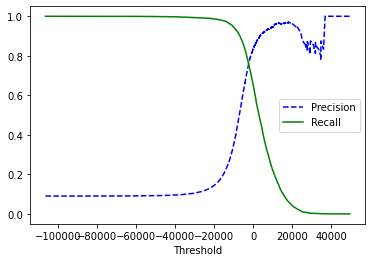

In [ ]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

A continuación se mostrará el gráfico de precisión vs sensibilidad.

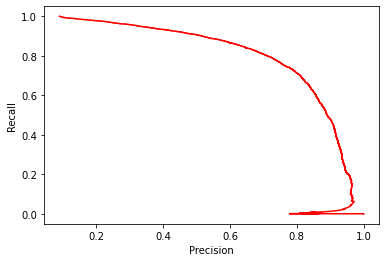

In [ ]:
plt.plot(precisions[:-1], recalls[:-1], "r-")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

Si es que se quiere maximizar tanto la precision y la sensibilidad, el punto ideal corresponde al punto codo de la gráfica anterior.

### Curva ROC
Otro criterio importante para determinar la efectividad de un clasificador es utilizar y analizar la curva ROC. ROC viene de ***Receiver Operating Characteristics*** y consiste en graficar el ratio de verdadero positivo (TPR) v/s el ratio de falso positivo (FPR). TPR es simplemente otro nombre para la sensibilidad o *recall* que ya hemos visto, mientras que FPR es el porcentaje que el clasificador se equivoca en predecir la categoria, es lo mismo que $1-TNR$, donde TNR (True Negative Rate) es el porcentaje de veces que el clasificador acierta un negativo. Puesto en formula tenemos:
$$ TNR = \frac{TN}{TN + FP} $$
$$ FPR = 1 - TNR $$
$$ TPR = recall = \frac{TP}{TP + FN} $$
$$ ROC = FPR\ v/s\ TPR  $$

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

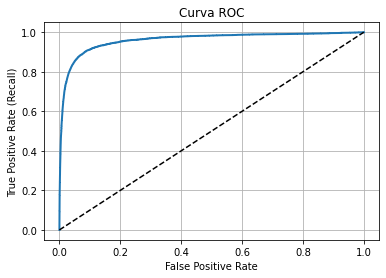

In [ ]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.grid(b=True)
plt.show()

La línea punteada corresponde a la curva ROC de un clasificador totalmente aleatoreo, mientras más alejada sea la curva ROC de esta línea, mayor es el desempeño, se puede ver también que a medida que aumenta la sensibilidad, la tasa de falso positivo también aumenta, por lo que existe un sacrificio, obviamente, mientras el punto codo esté más cerca de la esquina superior izquierda, mejor puede ser el desempeño a una menor tasa de falso positivos. Una métrica que se puede extraer es el área bajo la curva, mientras más cercano a 1, mejor es el clasificador, en cambio, mientras más cercano a 0.5, peor es el desempeño, a esta métrica se le llama **AUC** ('*Area Under Curve*'). El área se puede calcular de la siguiente forma.

In [ ]:
from sklearn.metrics import roc_auc_score
print(f'AUC: {roc_auc_score(y_train_5, y_scores)}')

AUC: 0.9604938554008616


> Cuando la cantidad de elementos positivos es bajo (en este caso la cantidad de numeros 5 en la base de datos), conviene mucho más utilizar la curva de precisión v/s sensibilidad, ya que en estos casos la curva ROC tiende a tener valores más positivos que los que se obtienen con la curva PR.

### Comparación entre clasificadores

A continuación procederemos a comparar el desempeño de nuestro clasificador SGD, con un clasificador de arboles aleatorios. Antes eso sí, no explicamos que para realizar la gráfica utilizamos los puntajes obtenidos por SGD, sin entrar en detalles, es importante saber que RFC (*Random Forest Classifier), no utiliza puntajes, sino probabilidades de pertenencia, es por esto que para graficar el ROC de RFC, utilizaremos dichas probabilidades, en otros modulos se entenderá en detalle como funciona cada clasificador.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, 
    X_train,
    y_train_5,
    cv=3, method='predict_proba')

> `y_probas_forest` contiene una matriz, donde cada fila es una instancia de la base de datos y cada columna representa a la probabilidad de que pertenezca a una clase, siendo el numero de columnas igual al numero de categorias.

In [ ]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

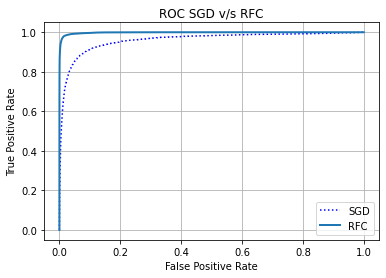

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="RFC")
plt.title("ROC SGD v/s RFC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(b'True')
plt.legend()
plt.show()

Podemos ver que el clasificador de arboles aleatorios pareciera funcionar mucho mejor! calculando su AUC obtenemos:

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Claramente mucho mejor. Pudimos ver en esta sección el comportamiento general de los clasificadores binarios, en la siguiente sección nos enfocaremos netamente en clasificadores de más de dos categorias y observaremos las diferencias al momento de evaluar su desempeño.